# Домашнее задание 2. Классификация, детекция.

Оценка за часть 1 и часть 2 в этом дз -- по 5 баллов.


## Часть 1. Классификация

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в датасете есть. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train и val, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат собственно сами изображения.
 
__Задание__. Добейтесь accuracy **не менее 0.44**. Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи/блогпосты/вопросы на stackoverflow/видосы от (индийских) ютуберов/курсы/подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

В коде ниже необходимо, чтобы код проходил все `assert`'ы.

Необходимо написать функцию `predict` по шаблону ниже. Эта функция принимает на вход модель, даталоадер с валидационнами данными, criterion для подсчёта лосса и device, на котором будут производиться вычисления (определён ниже) и возвращает список лоссов по всем объектам, список из предсказанных классов для каждого объекта из из даталоалера и список из настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено__. Можно использовать предобученные модели из `torchvision`.

__Критерии оценки__: Оценка вычисляется по простой формуле: min(5, 5 * Ваша accuracy / 0.44). Оценка округляется до десятых по арифметическим правилам.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать на защите :)
 - Используйте аугментации. Для этого пользуйтесь модулем torchvision.transforms или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - (ещё раз) Можно файнтюнить предобученные модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом ImageFolder), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы отладить код, пробуйте обучаться на маленькой части датасета. Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать гпу. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [1]:
# загрузка данных с гугл диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/hse-dl-hw2/dataset.zip 

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: dataset/dataset/val/class_101/00048.jpg  
  inflating: dataset/dataset/val/class_101/00049.jpg  
   creating: dataset/dataset/val/class_102/
  inflating: dataset/dataset/val/class_102/00000.jpg  
  inflating: dataset/dataset/val/class_102/00001.jpg  
  inflating: dataset/dataset/val/class_102/00002.jpg  
  inflating: dataset/dataset/val/class_102/00003.jpg  
  inflating: dataset/dataset/val/class_102/00004.jpg  
  inflating: dataset/dataset/val/class_102/00005.jpg  
  inflating: dataset/dataset/val/class_102/00006.jpg  
  inflating: dataset/dataset/val/class_102/00007.jpg  
  inflating: dataset/dataset/val/class_102/00008.jpg  
  inflating: dataset/dataset/val/class_102/00009.jpg  
  inflating: dataset/dataset/val/class_102/00010.jpg  
  inflating: dataset/dataset/val/class_102/00011.jpg  
  inflating: dataset/dataset/val/class_102/00012.jpg  
  inflating: dataset/dataset/val/class_102/00013.jpg  
  inflat

In [3]:
# убрать вывод предупреждений
import warnings
warnings.filterwarnings("ignore")

In [4]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import numpy as np
# You may add any imports you need
from PIL import Image
import os
from os.path import isfile, join
import torch.optim as optim
import sys
import torchvision.transforms as T
from tqdm import tqdm
import PIL

Для составления датасетов будет использоваться ImageFolder:

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform):
        pass
    def __getitem__(self, idx):
        pass
    def __len__(self, idx):
        pass

In [ ]:
# Just very simple checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

In [6]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, Normalize, ToTensor, Compose

train_transform = T.Compose(
    [T.RandomHorizontalFlip(),
     T.Resize(256),
     T.ToTensor()
     ])

val_transform = T.Compose(
     [T.RandomHorizontalFlip(),
     T.Resize(256),
     T.ToTensor()
     ])

train_dataset = ImageFolder("/content/dataset/dataset/train", transform=train_transform)
val_dataset = ImageFolder("/content/dataset/dataset/val", transform=val_transform)

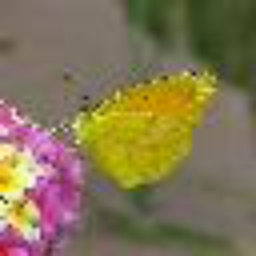

In [7]:
image, labels = next(iter(train_dataset))
image = T.ToPILImage()(image)
image

In [8]:
import tqdm
from sklearn.metrics import accuracy_score

def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm.tqdm(total=len(train_dataloader), file=sys.stdout) as prbar:
        for images, labels in train_dataloader:
            # Move Batch to GPU
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            # Update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Update descirption for tqdm
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
    metrics = {'loss': total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    return metrics, all_losses


def predict(model, val_dataloader, criterion, device="cuda:0"):
    model.to(device)
    model.eval()
    # predict val_dataloader and print and return the validation accuracy
    total_loss = 0
    num_batches = 0
    predicted_classes = np.array([])
    true_classes = np.array([])
    losses = np.array([])
    
    with tqdm.tqdm(total=len(val_dataloader), file=sys.stdout) as prbar:
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            accuracy = accuracy_score(labels.cpu().detach().numpy(), predicted.argmax(1).cpu().detach().numpy())
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            losses = np.append(losses, loss.cpu().detach().numpy())
            predicted_classes = np.append(predicted_classes, predicted.argmax(1).cpu().detach().numpy())
            true_classes = np.append(true_classes, labels.cpu().detach().numpy())
            num_batches += 1

    return losses, predicted_classes, true_classes


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    model.to(device)
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(n_epochs):
        # Train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_one_epoch(
            model=model,
            train_dataloader=train_dataloader,
            criterion=criterion,
            optimizer=optimizer
        )
        # Save Train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics['loss'])
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            losses, predicted_classes, true_classes = predict(
                model=model,
                val_dataloader=val_dataloader,
                criterion=criterion,
                device=device
            )
        # Save eval losses
        epoch_eval_losses.append(losses)

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [10]:
from torchvision.models import resnet18

model = resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(512, 200)

optimizer = torch.optim.Adam(model.fc.parameters(), 1e-4)
criterion = nn.CrossEntropyLoss()

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

#scheduler = # LR SCHEDULE THAT YOU PROBABLY CHOOSE

n_epochs = 5
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Простой тест на проверку правильности написанного кода

In [11]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

Loss: 4.9532 Accuracy: 0.0: 100%|██████████| 313/313 [00:22<00:00, 14.14it/s]
tests passed


Запустить обучение можно в ячейке ниже.

In [12]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs)

Train Epoch: 0
Loss: 3.1443 Accuracy: 43.75: 100%|██████████| 3125/3125 [03:42<00:00, 14.06it/s]
Validation Epoch: 0
Loss: 3.0512 Accuracy: 56.25: 100%|██████████| 313/313 [00:22<00:00, 13.96it/s]
Train Epoch: 1
Loss: 2.7142 Accuracy: 40.625: 100%|██████████| 3125/3125 [03:44<00:00, 13.92it/s]
Validation Epoch: 1
Loss: 2.1965 Accuracy: 56.25: 100%|██████████| 313/313 [00:22<00:00, 13.95it/s]
Train Epoch: 2
Loss: 1.7887 Accuracy: 62.5: 100%|██████████| 3125/3125 [03:47<00:00, 13.73it/s]
Validation Epoch: 2
Loss: 2.2162 Accuracy: 56.25: 100%|██████████| 313/313 [00:23<00:00, 13.53it/s]
Train Epoch: 3
Loss: 2.1947 Accuracy: 46.875: 100%|██████████| 3125/3125 [03:51<00:00, 13.47it/s]
Validation Epoch: 3
Loss: 1.5892 Accuracy: 75.0: 100%|██████████| 313/313 [00:23<00:00, 13.60it/s]
Train Epoch: 4
Loss: 2.1251 Accuracy: 53.125: 100%|██████████| 3125/3125 [03:49<00:00, 13.61it/s]
Validation Epoch: 4
Loss: 1.5917 Accuracy: 68.75: 100%|██████████| 313/313 [00:23<00:00, 13.56it/s]


После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, запустите функцию evaluate. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [13]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print("Оценка за это задание составит {} баллов".format(min(5, 5*accuracy / 0.44)))

Loss: 1.6213 Accuracy: 75.0: 100%|██████████| 313/313 [00:23<00:00, 13.31it/s]
Оценка за это задание составит 5 баллов


__Ваш отчёт о проделанных экспериментах__: \\
Какие параметры менялись и как от них зависело качество: \\
1) batch_size \\
При размерах батчей 256 максимальное значение accuracy на валидационных данных доходило до 37.5, поэтому batch_size было принято брать меньше   \\
Наилучшее наибольшее качество достигалось при batch_size = 32 (max accuracy = 43.75) \\

2) число эпох \\
При числе эпох = 10 происходило переобучение - на 6 эпохе модель (почти) без аугментаций показывала accuracy на тесте = 50, затем качество падало -> нужно меньшее число эпох \\
На 5 эпохах качество не падает, модель не переобучается \\
(идея взята отсюда: https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9)

3) learning rate \\
Оптимайзер - Adam, так как с другими оптимайзерами (SGD и Adagrad) модель быстро переобучалась \\
Если поставить learning rate в Adam = 1e-5 - обучение происходит очень медленно, на второй эпохе качество 1.2 \\
Если повысить learning rate до 1е-3, то модель быстро переобучается \\
При learning rate = 1e-4 скорость обучения оптимальная

4) аугментации \\
При добавлении аугментации RandomRotation max accuracy = 25.0 \\
При применении только RandomHorizontalFlip для тренировочного датасета max accuracy = 35.0 \\
При аугментациях RandomHorizontalFlip, ColorJitter, ToTensor и Normalize  max accuracy = 43.75 \\

Так как берется предобученная модель ResNet, которая обучалась на датасете ImageNet (картинки 256х256), то логично было изменить размер картинок с 64х64 до 256х256 \\
Также, поскольку много аугментаций может сильно испортить данные, было решено оставить только RandomHorizontalFlip \\ 
В итоге, с минимумом аугментаций, но с препроцессингом данных (Resize), качество модели заметно улучшилось. \\

(идея с resize честно взята из обсуждения в чате майнора) \\
(варианты аугментаций брались отсюда: https://pytorch.org/docs/stable/torchvision/transforms.html) \\
(описание ImageNet: https://devopedia.org/imagenet) \\




## Часть 2. Object detection.

В этом задании потребуется обучить детектор фруктов на изображении. Датасет можно скачать [отсюда](https://yadi.sk/d/UPwQB7OZrB48qQ).

In [2]:
!unzip /content/drive/MyDrive/hse-dl-hw2/archive.zip

Archive:  /content/drive/MyDrive/hse-dl-hw2/archive.zip
  inflating: test_zip/test/apple_77.jpg  
  inflating: test_zip/test/apple_77.xml  
  inflating: test_zip/test/apple_78.jpg  
  inflating: test_zip/test/apple_78.xml  
  inflating: test_zip/test/apple_79.jpg  
  inflating: test_zip/test/apple_79.xml  
  inflating: test_zip/test/apple_80.jpg  
  inflating: test_zip/test/apple_80.xml  
  inflating: test_zip/test/apple_81.jpg  
  inflating: test_zip/test/apple_81.xml  
  inflating: test_zip/test/apple_82.jpg  
  inflating: test_zip/test/apple_82.xml  
  inflating: test_zip/test/apple_83.jpg  
  inflating: test_zip/test/apple_83.xml  
  inflating: test_zip/test/apple_84.jpg  
  inflating: test_zip/test/apple_84.xml  
  inflating: test_zip/test/apple_85.jpg  
  inflating: test_zip/test/apple_85.xml  
  inflating: test_zip/test/apple_86.jpg  
  inflating: test_zip/test/apple_86.xml  
  inflating: test_zip/test/apple_87.jpg  
  inflating: test_zip/test/apple_87.xml  
  inflating: test_zi

In [3]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-8ny9_77m
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-8ny9_77m
     |████████████████████████████████| 952kB 9.3MB/s 
  Created wheel for albumentations: filename=albumentations-0.5.1-cp36-none-any.whl size=72066 sha256=c006e49eb6e378059a45b2fe167db448f2d9445c7fbfe3197b8eada4650e3958
  Stored in directory: /tmp/pip-ephem-wheel-cache-1dric9po/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [4]:
# we will need this library to process the labeling
! pip install xmltodict

In [5]:
import xmltodict, json

Датасет мы за вас написали.

In [27]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import xmltodict
import json
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc
# add any imports you need
import albumentations as A
import torchvision.transforms as T

In [28]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}

class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it =)
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            # применим permute, чтобы число каналов в тензоре стояло на 
            # первом месте (dimension=0)
            return torch.tensor(res["image"]).permute(2, 0, 1), {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return torch.tensor(self.images[i]), torch.tensor(self.annotations[i])

    def __len__(self):
        return len(self.images)

Выпишем кое-какую техническую работу, которая уже была на семинаре.

In [29]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device):
    results = []
    model.to(device)
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))


    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

Вам мы оставляем творческую часть =)

__Задание__. Обучите модель для object detection на __обучающем__ датасете и добейтесь PR-AUC не менее __0.91__ на  __тестовом__.

 - Создайте модель и оптимайзер
 - Напишите функцию обучения модели
 - Используйте аугментации
 
Использовать аугментации для обучения __обязательно__. Они дадут 1 балл из 5. Пользуйтесь модулем torchvision.transforms или библиотекой albumentations (о которой говорилось ранее). Последняя библиотека особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Советуем обратить внимание на следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). Обратите внимание, что код, написанный в датасете выше, верен только если вы используете albumentations. Если вы выбрали путь torchvision.transforms, вам потребуется метод `__getitem__` изменить (что-то типа `return self.transform(self.images[i])`; однако в таком случае вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную =))

Оставшиеся 4 балла вычисляются по простой формуле: __min(4, 4 * Ваш auc / 0.91)__.

In [30]:
def train_one_epoch(model, train_dataloader, optimizer, device):
    n = 0
    global_loss = 0
    for images, targets in train_dataloader:
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        dict_loss = model(images, targets)
        losses = sum(loss for loss in dict_loss.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        n += 1
        global_loss += float(losses.cpu().detach().numpy())

        if n % 10 == 0:
            print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2)))

    return global_loss


def train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs=10):
    for epoch in range(n_epochs):
        model.eval()
        a = evaluate(model, val_dataloader, device=device)
        print("AUC ON TEST: {}".format(a))
        print('EPOCH #', epoch + 1)
        model.train()
        train_one_epoch(model, train_dataloader, optimizer, device=device)

In [31]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [32]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [37]:
labels = [1, 2, 3]

train_transform = A.Compose([
        A.ToFloat(),
        A.HorizontalFlip(p=0.5),
    ],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
)
val_transform = A.Compose([
        A.ToFloat()
    ],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
)

train_dataset = FruitDataset("./train_zip/train", transform=train_transform)
val_dataset = FruitDataset("./test_zip/test", transform=val_transform)

def get_detection_model(num_classes=3):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


num_classes = 4 # классы apple, orange, banana и фон 
model = get_detection_model(num_classes)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn)

n_epochs = 10 
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [38]:
train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs)

AUC ON TEST: 0.0017596125713125216
EPOCH # 1
Loss value after 10 batches is 0.7
Loss value after 20 batches is 0.58
Loss value after 30 batches is 0.53
Loss value after 40 batches is 0.49
Loss value after 50 batches is 0.45
Loss value after 60 batches is 0.43
Loss value after 70 batches is 0.42
Loss value after 80 batches is 0.39
Loss value after 90 batches is 0.38
Loss value after 100 batches is 0.37
Loss value after 110 batches is 0.35
Loss value after 120 batches is 0.34
AUC ON TEST: 0.824878725012863
EPOCH # 2
Loss value after 10 batches is 0.22
Loss value after 20 batches is 0.22
Loss value after 30 batches is 0.21
Loss value after 40 batches is 0.21
Loss value after 50 batches is 0.21
Loss value after 60 batches is 0.2
Loss value after 70 batches is 0.2
Loss value after 80 batches is 0.2
Loss value after 90 batches is 0.2
Loss value after 100 batches is 0.2
Loss value after 110 batches is 0.2
Loss value after 120 batches is 0.19
AUC ON TEST: 0.8775795866919924
EPOCH # 3
Loss valu

__Выведите итоговое качество модели__.

In [39]:
auc = evaluate(model, val_dataloader, device=device)
print("Оценка за это задание составит {} баллов".format(min(4, 4 * auc / 0.91)))

Оценка за это задание составит 4 баллов


Нарисуйте предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета.

In [42]:
# заменим train_dataset на val_dataset
image, labels = next(iter(val_dataset))
pred = model(image.unsqueeze(0).to(device))[0]

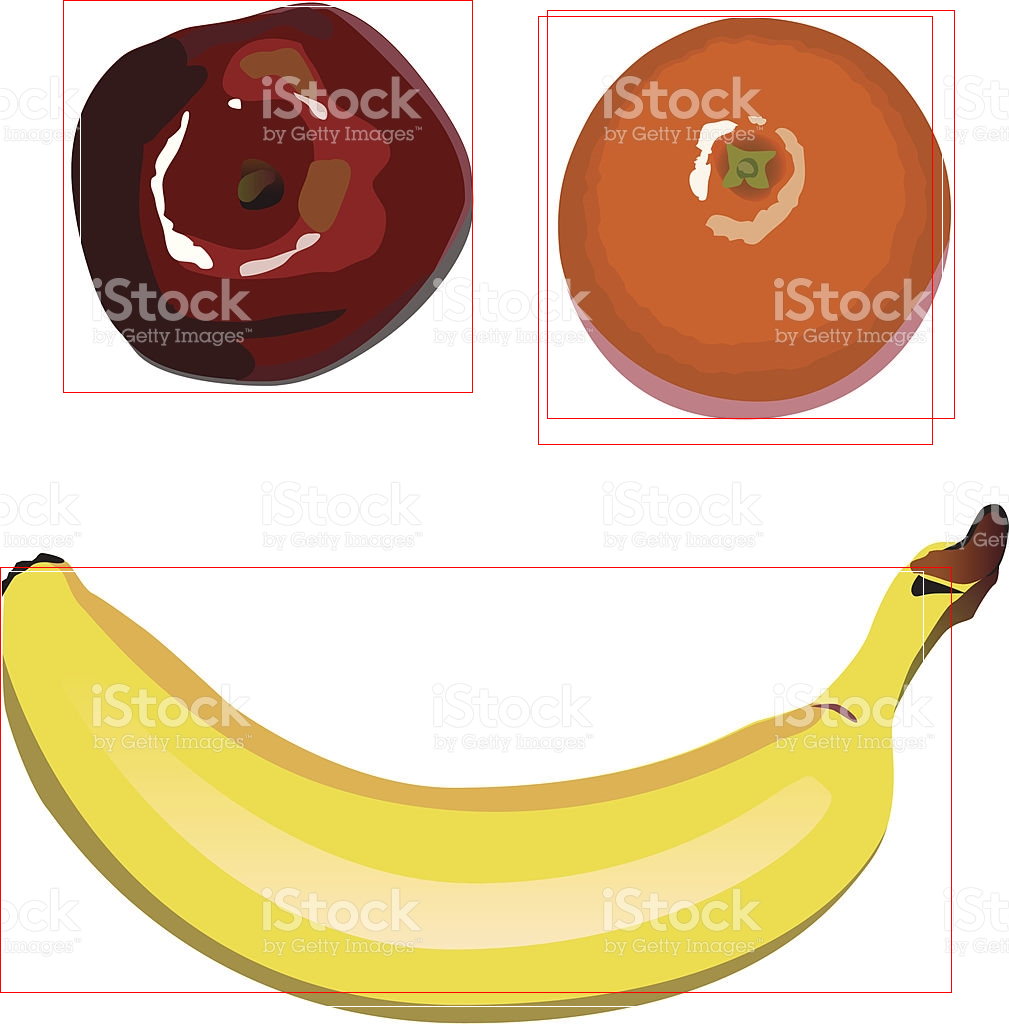

In [43]:
from PIL import ImageDraw

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

__Отчет:__ \\
С аугментациями ToFloat, Normalize и RandomFLip accuracy затем не поднималось выше 10 - картинки сильно портились \\
Normalize сильно ухудшало качество (не поднималось выше 11) \\
Минимальное количество аугментаций (HorizontalFlip при формировании тренировочного датасета) помогло достичь нужной точности

Источники, использованные при написании кода: \\
https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/ \\
https://github.com/albumentations-team/albumentations_examples/blob/master/notebooks/example_bboxes.ipynb \\
https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms \\


 

In [ ]:
# бонусная часть - неактуальная, потому что ноутбук был заполнен до изменения бонуса

## Бонус (10 баллов).

__Задание__. В части с классификацией добейтесь accuracy не менее 0.52. Напишите отчёт о проделанных экспериментах.

__Критерии оценки__. Оценка за бонусную часть равна 10, если вы преодолели качество 0.52 и 0 в противном случае.

__Иных оценок кроме 0 и 10 не предусмотрено__.

In [77]:
# YOUR CODE

## Бонус (0 баллов).

__Задание 1__. Скиньте ниже смешную картинку, желательно про машинное обучение. На картинке не должно быть никаких упоминаний лектора, семинаристов и ассистентов этого курса.

__Задание 2__. Расскажите, как вам задание? Что понравилось, что не понравилось, что можно улучшить? Мы примем во внимание любой фидбек.

2) Задания понравились, особенно написанный класс для датасета и почти все функции для обучения во второй части :) Очень помогли советы в самом начале, а также ссылка на гайд по аугментациям во второй

1)

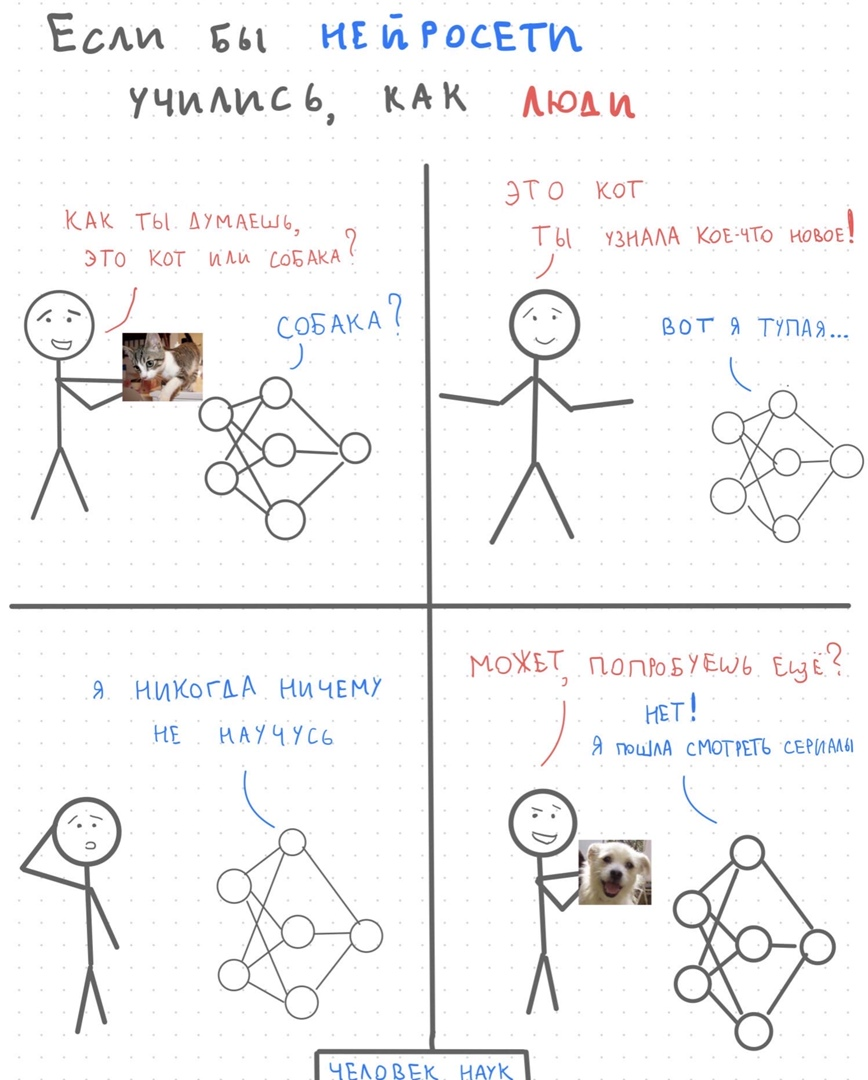


